In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("./data"))

## Adding in some more useful packages here
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

['test.csv', 'train.csv', 'sample_submission.csv']


In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
train.shape

(1306122, 3)

In [5]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 1.13.1


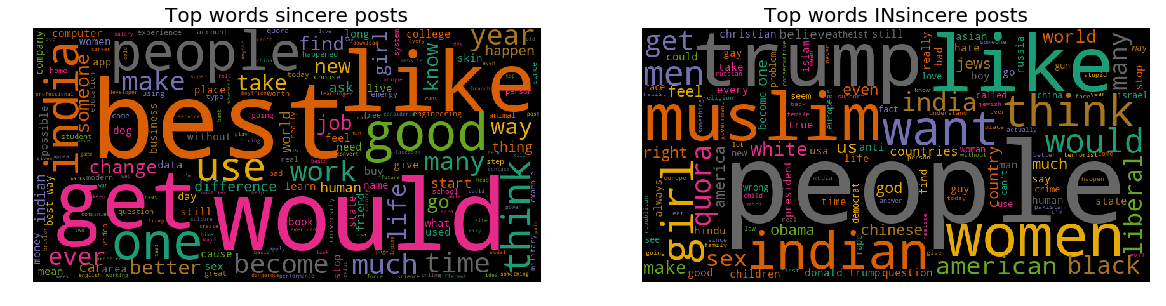

In [6]:
n_posts = 1000
q_S = ' '.join(train[train['target'] == 0]['question_text'].str.lower().values[:n_posts])
q_I = ' '.join(train[train['target'] == 1]['question_text'].str.lower().values[:n_posts])

wordcloud_S = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_S)
wordcloud_I = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_I)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_S)
ax[0].set_title('Top words sincere posts',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_I)
ax[1].set_title('Top words INsincere posts',fontsize = 20)
ax[1].axis("off")

plt.show()

In [7]:
import re

## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in train['question_text'].values: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

print(texts[0:5])

[['quebec', 'nationalists', 'see', 'province', 'nation', '1960s'], ['adopted', 'dog', 'would', 'encourage', 'people', 'adopt', 'shop'], ['velocity', 'affect', 'time', 'velocity', 'affect', 'space', 'geometry'], ['otto', 'von', 'guericke', 'used', 'magdeburg', 'hemispheres'], ['convert', 'montra', 'helicon', 'mountain', 'bike', 'changing', 'tyres']]


In [8]:
## Code adapted from (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# Vectorize the text samples

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(train['target']))
print(data.shape)
print(labels.shape)

Using TensorFlow backend.


Found 195238 unique tokens.
(1306122, 100)
(1306122, 2)


In [9]:
embeddings_index = {}
f = open('./embeddings/glove.840B.300d/glove.840B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print("GloVe Data Loaded")

GloVe Data Loaded


In [10]:
## More code adapted from the keras reference (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# prepare embedding matrix 
from keras.layers import Embedding
from keras.initializers import Constant

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Now to create and visualize a model.

In [11]:
# Code from: https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

model = Sequential()
model.add(Embedding(num_words, 300, input_length=100, weights= [embedding_matrix], trainable=False))

model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
print(labels.shape)
model.fit(data, np.array(labels), validation_split=0.1, epochs = 1)

(1306122, 2)
Instructions for updating:
Use tf.cast instead.
Train on 1175509 samples, validate on 130613 samples
Epoch 1/1
1175509/1175509 [==============================] - 2448s 2ms/step - loss: 0.1558 - acc: 0.9455 - val_loss: 0.1533 - val_acc: 0.9461


In [14]:
test = pd.read_csv('./data/test.csv')
test.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [23]:
# Import the confusion matrix function.

from sklearn.metrics import confusion_matrix

In [24]:
# Generate our predictions.

predictions = model.predict(X_test_cvec)

In [25]:
# Generate a confusion matrix.

confusion_matrix(y_test, predictions)

array([[235,   3],
       [ 11,   1]])

In [26]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [27]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 235
False Positives: 3
False Negatives: 11
True Positives: 1


In [28]:
accuracy = (tp + tn)/(tn+fp+fn+tp)
print("Accuracy: %s" % accuracy)
precision = tp/(tp+fp)
print("Precision: %s" % precision)
recall = tp/(tp+fn)
print("Recall: %s" % recall)
f1_score = (precision*recall)/(precision+recall)
print("F1 Score: %s" % f1_score)

Accuracy: 0.944
Precision: 0.25
Recall: 0.08333333333333333
F1 Score: 0.0625
